## BikeMi Stalls *k*-Means Clustering

In [1]:
# path manipulation
from pathlib import Path

# data manipulation
import pandas as pd
import geopandas

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# connecting to a database
import psycopg2

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set settings for seaborn
sns.set_style(style="whitegrid", rc={"grid.color": ".9"})
sns.set_palette(palette="deep")

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
title_font: dict[str] = {"fontname": "DejaVu Sans Mono"}

# create paths
milan_data: Path = Path("../data/milan")

# establish connection with the database
conn = psycopg2.connect("dbname=bikemi user=luca")

bikemi_stalls: pd.DataFrame = pd.read_sql("SELECT * FROM bikemi_selected_stalls", conn).set_index("numero_stazione")

### Further Dimensionality Reduction

After our first data selection to remove outliers and restrict the spatial area in which we are conducting our analysis,
we are still left with more than 200 stations, spread across 25 neighbourhoods out of 88 - identified by the acronym NIL, i.e. *nuclei d'identità locale*. This figure might still be too high, especially as far as multivariate models are concerned: indeed, shrinkage will be necessary in order to avoid highly correlated features (*multicollinearity*).
However, it is still in our interests to reduce the number of series to model even for the univariate forecasting: fitting twenty or two-hundred series is a different task. Even inspecting the correlation across series becomes a daunting task with such a great number of features.

To do so, we will use *k*-means clustering - a popular method widely used in the sharing-services literature, especially to identify "virtual stations" in free-float services <cite id="54l2o">(Ma et al., 2018)</cite> or to "visualize the spatial distribution of DBS [Dockless Bike Sharing] and taxis around metro stations" <cite id="ai9ag">(Li et al., 2019)</cite>.

In a few words, with *k*-means clustering  we "want to partition the observations into $K$ clusters such that the total within-cluster variation [also known as  *inertia*], summed over all $K$ clusters, is as small as possible" <cite id="is7ue">(Sohil et al., 2021)</cite>. The objective function to optimise is usually the squared Euclidean distance. Simply put, *k*-means "aims to partition n observations into $K$ clusters, represented by their centres or means. The centre of each cluster is calculated as the mean of all the instances belonging to that cluster" <cite id="z2z8d">(Li et al., 2019)</cite> and "is extremely efficient and concise for the classification of equivalent multidimensional data" such as sharing services data <cite id="ter8l">(Li et al., 2019)</cite>.

The algorithm begins with randomly choosing clusters centres and, with each iteration, the centres are re-calculated to reduce the partitioning error - which decreases monotonically, as $K$ increases. Basically, in this second step the algorithm "creates new centroids by taking the mean value of all of the samples assigned to each previous centroid [...] until the centroids do not move significantly" <cite id="wx6bz">(<i>Clustering</i>, n.d.)</cite>. However, despite similarity always increasing, values of $K$ that are too great defy the purpose of this classification algorithm. For this reasons, practitioners and researchers have come up with more or less sophisticated ways to assess the optimal number of clusters, the most common of which is the so-called "Elbow method". In a few words, a chosen performance metric is computed for each number of clusters and the optimum is represented by the point at which the performance improvements start to marginally decline.

*k*-Means clustering scales well with the number of samples $n$, but assumes convex shapes (i.e., has worse performances where the "true" clusters have elongated or irregular shapes) <cite id="hqe2q">(<i>Clustering</i>, n.d.)</cite>. Besides, since the initial position of the cluster is random, it might take some attempt for the algorithm to converge. More importantly, however, *k*-Means is sensitive to the scales of the variables in the data, so normalising the feature matrix is a crucial step. Finally, *k*-Means assumes continuous data and is not designed to handle categorical features: "[T]he *k*-means algorithm only works on numerical data, i.e. variables that are measured on a ratio scale [...], because it minimises a cost function by changing the means of clusters. This prohibits it from being used in applications where categorical data are involved" <cite id="qio8u">(Huang, 1998)</cite>.

Some workarounds have long been studied in the literature: as an example, by changing the distance metrics from the Euclidean distance to the Gower distance, which is a measure of similarity <cite id="xliyv">(Gower, 1971)</cite>, *k*-Means can be adjusted to cluster categorical variables. More recently, new methods have been developed, such as the *k*-Modes <cite id="wx7f9">(Huang, 1998)</cite>. These alternative methods rose in popularity because the "quadratic computational costs" of similarity-based algorithms are not suited for the larger and larger datasets we have been dealing with, especially in the past years.

Our context does not warrant new, sophisticated clustering algorithms. The sample size of the spatial distribution of stalls would even be small enough to justify an attempt with similarity scores. Yet, to the best of our knowledge, this procedure has not been tried yet in the literature, and there are plenty of good reasons for doing so.

As a starter, the categorical variables we have - like the neighbourhood - are just another measure of geographic distribution. It would be much more meaningful to run the *k*-means algorithm with other, quantitative features, such as the number of stations or bike lanes in the proximity of the station. The nature and number of buildings, like the extension of parks or traffic measurements, could be used, too. This procedure of data collection should take a lot of time and diversified skills and would primarily accomplish the goal to provide a better segmentation of the individual stations: as an example, it could represent an improvement over choosing neighbourhood fixed effects. While the level of accuracy of such an approach could be much greater, this is nothing that would not be similarly accomplished by "arbitrarily" selecting stations close to each other (say, within a radius of a couple of hundred metres, or that varies according to the population density of the area). Given the nature of our task - forecasting - we shall stick to the usage of *k*-means that is prevalent in the literature: identify virtual stations to reduce dimensionality and perhaps offer new insights as far as data analysis is concerned.

In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

coord_stalls: pd.DataFrame = bikemi_stalls.filter(["latitudine", "longitudine"])

The main, if not only, hyperparameter to tune in *k*-means is, indeed, the number of clusters.
As most machine learning methods, *k*-means is a quite old algorithm and has thus been widely studied.
The first metric to look at is indeed the inertia, or *within-cluster sum-of-squares* ($WSS$), which is usually computed using the Euclidean norm:

$$\sum_{i=0}^{n}\underset{\mu_{j}\in{C}}{min}(||x_{i} - \mu_{j}||^2)$$

Other norms can be used; however, some other performance metrics can only be calculated with the Euclidean distance. While clustering is usually presented as an unsupervised machine-learning technique, a first set of metrics is actually computed comparing the clustering with the ground truths. This is necessary because the evaluation metrics should not take into account the absolute number of clusters, yet if this clustering defines "separations of the data similar to some ground truth set of classes" **SKLEARN**.

Among these metrics there are the *Rand index*, mutual information-based scores, measures of completeness and homogeneity (or both, such as the *V-measure*) and Fowlkes-Mallows scores. There is, however, another category of metrics that does not require a comparison with the ground-truth: the *silhouette coefficients*, the *Calinski-Harabasz index*, computed as  and  the *Davies-Bouldin index*. The dowside of these evaluation metrics is that they are not robust against "unconventional" shapes and tend to display "better" values when the clusters are convex.

These measures are computed for each set of data points and the labels assigned with the *k*-means. The silhouette score is computed as $s = \frac{b - a}{max(a, b)}$, where $a$ is the mean distance between a sample and all points in the same class and $b$ is the average distance between the sample and the points in the *next nearest* cluster. The silhouette coefficients for all samples are averaged and a higher silhouette coefficient relates to a model with better defined clusters **SKLEARN**. For this reason, the silhouette score is defined within $[-1;1]$, and scores closer to $-1$ denote incorrect clustering and values near $0$ indicate overlapping data points.

The Calinski-Harabasz Index is defined as:

$$ s = \frac{\mathrm{tr}(B_k)}{\mathrm{tr}(W_k)} \times \frac{n_E - k}{k - 1}$$

Where $B_k$ is the dispersion between clusters and $W_k$ is the one within clusters and $n$ is the number of observations in the dataset $E$. Because of this, the index is a raw number (i.e., it is not normalised between, say, $0$ and $1$). Since we want the clusters to be as far apart as possible and the points inside to be as close as possible, we will choose $K$ such as it maximises the Calinski-Harabasz index.

Finally, the Davies-Bouldin index indicates a better separation between clusters the lower it is, and is computed as the average similarity across the two closer classes $C_i$ and $C_k$. The similarity measure between $C_i$ and $C_k$ is called $R_{ij}$ and is defined as $R_{ij} = \frac{s_i + s_j}{d_{ij}}$, where $s$ is the average distance between each point of a cluster and its centre, and $d_{ij} is the distance between the two clusters' centroids. The Davies-Bouldin index is thus formally defined as such:

$$DB = \frac{1}{k} \sum_{i=1}^k \max_{i \neq j} R_{ij}$$

In [56]:
def get_kmeans_metrics(data, k_max, random_state):
    scaled_data = StandardScaler().fit_transform(data)
    k_range = range(2, k_max + 1)

    def compute_scores(source_data, num_clusters, rand):
        # fit kmeans
        kmeans = KMeans(num_clusters, random_state=rand).fit(data)

        # scores
        inertia = kmeans.inertia_
        silhouette_coefficient = silhouette_score(source_data, kmeans.labels_, metric="euclidean")
        calinski_harabasz = calinski_harabasz_score(source_data, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(source_data, kmeans.labels_)

        return inertia, silhouette_coefficient, calinski_harabasz, davies_bouldin

    scores = [compute_scores(scaled_data, k, random_state) for k in k_range]

    output = pd.DataFrame(
        scores,
        index=k_range,
        columns=["inertia", "silhouette_coefficient", "calinski_harabasz", "davies_bouldin"]
    )
    output.index.name = "k"

    return output


metrics = get_kmeans_metrics(coord_stalls, 70, 42)

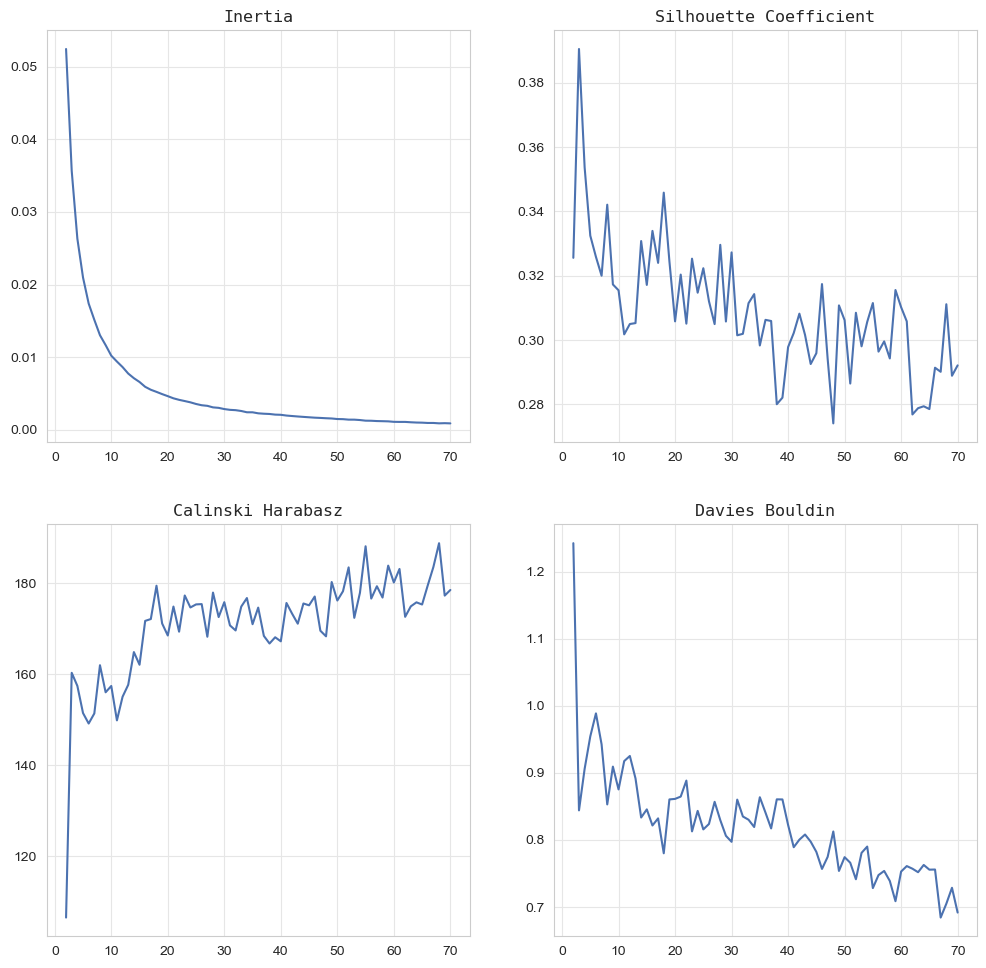

In [76]:
def plot_all_metrics(data: pd.DataFrame):
    def plot_metric(dataf: pd.DataFrame, col: str, ax: plt.Axes):
        plot_title: str = col.replace("_", " ").title()
        ax.plot(dataf[col])
        ax.set_title(f"{plot_title}", **title_font)


    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    for ax, metric in zip(ax.reshape(-1), metrics.columns):
        plot_metric(metrics, metric, ax)

plot_all_metrics(metrics)

The $WSS$ or inertia is not really indicative of a significant value of $K$. The silhouette coefficient is greatest for a quite small number of clusters (smaller than 5) and in general not greater than 20. This appears to be the case for the Calinski-Harabasz index too and, while the same cannot be said of the Davies-Bouldin index, beyond said threshold the index is bound to improve. Our final choice falls on 18, as we believe that clustering the whole set of stations into three great clusters bears no practical utility for the purpose of the policymaker - forecasting the bikes demand in Milan.

In [70]:
from sklearn.pipeline import make_pipeline

def fit_kmeans(k, rand):
    return make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=rand))

final_estimator = fit_kmeans(k=18, rand=42).fit(coord_stalls)

clustered_stalls: geopandas.GeoDataFrame = (
    coord_stalls
        .assign(cluster = final_estimator[-1].labels_)
        .pipe(
            geopandas.GeoDataFrame,
            geometry=geopandas.points_from_xy(coord_stalls.latitudine, coord_stalls.longitudine, crs=4326)
        )
        .filter(["cluster", "geometry"])
)

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/14/10260/7770.png

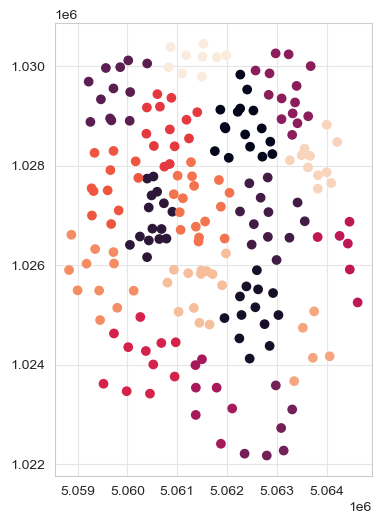

In [88]:
import contextily as cx

def plot_clusters(geodata):

    fig, ax = plt.subplots()

    geodata.to_crs(3857).plot(column="cluster", ax=ax)
    cx.add_basemap(ax=ax)

plot_clusters(clustered_stalls)

In [ ]:
The
same
exercise
can
be
repeated
with the whole set of stalls:

In [77]:
def parse_coordinates(data: pd.DataFrame, col: str, inplace: bool = False) -> pd.DataFrame:
    if not inplace:
        df = data.copy()


stalls_full = (
    pd.read_sql("SELECT * FROM bikemi_stalls_before_2019", conn)
)



,numero_stazione,nome,municipio,anno,geometry
0,1,Duomo,1,2008,"(45.4647459734079, 9.18914146264192)"
1,402,San Babila Bis,1,2008,"(45.4662661364932, 9.19725017347504)"
2,3,Cadorna 1,1,2008,"(45.4680028648953, 9.17566167305516)"
3,4,Lanza,1,2008,"(45.4722739800171, 9.18197005904561)"
4,5,Universita' Cattolica,1,2008,"(45.4631209673784, 9.17641155359657)"


In [82]:
stalls_full.head()

,numero_stazione,nome,municipio,anno,geometry
0,1,Duomo,1,2008,"(45.4647459734079, 9.18914146264192)"
1,402,San Babila Bis,1,2008,"(45.4662661364932, 9.19725017347504)"
2,3,Cadorna 1,1,2008,"(45.4680028648953, 9.17566167305516)"
3,4,Lanza,1,2008,"(45.4722739800171, 9.18197005904561)"
4,5,Universita' Cattolica,1,2008,"(45.4631209673784, 9.17641155359657)"
